<a href="https://colab.research.google.com/github/DianaAkolzina/scientific_paper_classifier/blob/scibert/scibert_finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from google.cloud import bigquery
import numpy as np
import logging
from torch.utils.tensorboard import SummaryWriter
from transformers.trainer_utils import EvalPrediction
from transformers import EarlyStoppingCallback
from google.colab import auth
import torch.nn as nn

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

auth.authenticate_user()
project_id = "scientific-paper-classifier"
client = bigquery.Client(project=project_id)

In [ ]:
query = """
SELECT Processed_Text,  Label
FROM data_train.processed_text_10000
"""
df = client.query(query).to_dataframe()
logging.info(f"Retrieved {len(df)} rows from BigQuery")

In [ ]:
# Data Preprocessing and Balancing
text_column = 'Processed_Text'
label_column = 'Label'

combined_df = df
combined_df.reset_index(drop=True, inplace=True)
combined_df['Label'] = combined_df['Label'].astype('category')
logging.info(f"Preprocessed data: {combined_df.shape}")

label_counts = combined_df['Label'].value_counts()
min_category_size = label_counts.min()
balanced_df = pd.concat([
    combined_df[combined_df['Label'] == label].sample(n=min_category_size, random_state=42)
    for label in combined_df['Label'].cat.categories
])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
logging.info(f"Balanced dataset: {balanced_df.shape}")

X = balanced_df['Processed_Text']
y = balanced_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logging.info(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

In [ ]:
# Tokenization and Dataset Creation
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

max_length = 256
batch_size = 32

def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.tolist())

    return TensorDataset(input_ids, attention_masks, labels)

train_dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)
logging.info(f"Tokenized data: Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

train_dataloader = DataLoader(
            train_dataset,
            sampler=None,
            batch_size=batch_size
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler=None,
            batch_size=batch_size
        )


In [ ]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(balanced_df['Label'].unique()))
model.to(device)
logging.info(f"Initialized SciBERT model with {model.num_parameters()} parameters")

# Fine-Tuning Parameters
epochs = 15
learning_rate = 2e-5

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)  # L2 regularization
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
logging.info(f"Training parameters: Epochs: {epochs}, Learning rate: {learning_rate}, Batch size: {batch_size}")

# Training and Test Losses
train_losses = []
test_losses = []

# Gradient Clipping
clip_grad_norm = 1.0

# Learning Rate Scheduling
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Fine-Tuning Loop with Gradient Clipping and Dropout
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    logging.info(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss}')

    # Learning Rate Scheduling
    lr_scheduler.step()

    # Validation
    model.eval()
    test_loss = 0

    for batch in tqdm(test_dataloader, desc='Validating'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        test_loss += outputs.loss.item()

    test_avg_loss = test_loss / len(test_dataloader)
    test_losses.append(test_avg_loss)
    logging.info(f'Epoch {epoch + 1}/{epochs}, Average Test Loss: {test_avg_loss}')



pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validating: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]


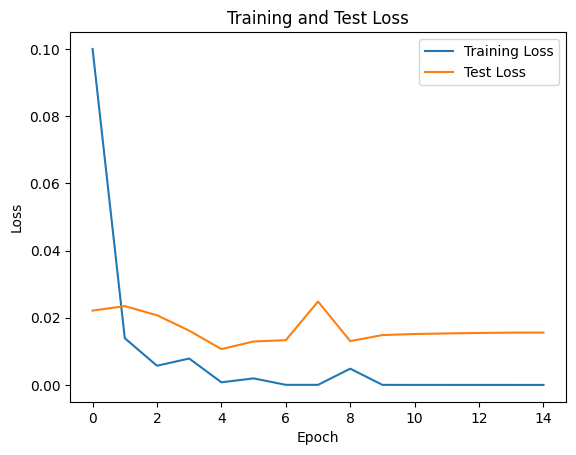

Overfitting detected: Training loss is significantly lower than test loss.


Evaluating: 100%|██████████| 29/29 [00:07<00:00,  3.98it/s]


Accuracy: 0.9967462039045553
Precision:
0: 0.9957356076759062
1: 0.9977924944812362
Recall:
0: 0.9978632478632479
1: 0.9955947136563876
F1-score:
0: 0.9967982924226253
1: 0.9966923925027563
Overall Precision: 0.9967640510785711
Overall Recall: 0.9967289807598178
Overall F1-score: 0.9967453424626909


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Plotting the learning curves
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Calculate the difference between training and test losses
loss_diff = [train_loss - test_loss for train_loss, test_loss in zip(train_losses, test_losses)]

# Detecting overfitting based on loss difference
overfitting_detected = any(diff > 0 for diff in loss_diff)

if overfitting_detected:
    print("Overfitting detected: Training loss is significantly lower than test loss.")
else:
    print("No significant signs of overfitting detected.")

# Evaluation
model.eval()
predictions, true_labels = [], []

for batch in tqdm(test_dataloader, desc='Evaluating'):
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

# Classification Report
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

class_names = [str(label) for label in balanced_df['Label'].unique().tolist()]

report = classification_report(flat_true_labels, flat_predictions, target_names=class_names)
logging.info(f"Classification Report:\n{report}")

# Calculate accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)

# Calculate precision, recall, and F1-score
report = classification_report(flat_true_labels, flat_predictions, target_names=class_names, output_dict=True)

# Extract precision, recall, and F1-score for each class
precision = {class_name: report[class_name]['precision'] for class_name in class_names}
recall = {class_name: report[class_name]['recall'] for class_name in class_names}
f1 = {class_name: report[class_name]['f1-score'] for class_name in class_names}

# Overall precision, recall, and F1-score
overall_precision = report['macro avg']['precision']
overall_recall = report['macro avg']['recall']
overall_f1 = report['macro avg']['f1-score']

# Print or log the metrics
print(f'Accuracy: {accuracy}')
print('Precision:')
for class_name, value in precision.items():
    print(f'{class_name}: {value}')
print('Recall:')
for class_name, value in recall.items():
    print(f'{class_name}: {value}')
print('F1-score:')
for class_name, value in f1.items():
    print(f'{class_name}: {value}')
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1-score: {overall_f1}')

In [ ]:
# Save and Load Model
model_path = 'scibert_fine_tuned_model_nevena2.pth'
torch.save(model.state_dict(), model_path)
logging.info(f"Fine-tuned model saved to: {model_path}")

# Load the Fine-Tuned Model
loaded_model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(balanced_df['Label'].unique()))
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)
logging.info("Fine-tuned model loaded successfully")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/MyDrive/model_directory2/model.safetensors')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gsutil cp /content/drive/MyDrive/model_directory2/model.safetensors gs://scientific_paper_classifier-bucket/models/scibert_model_nevena2.h5

Omitting directory "file:///content/drive/MyDrive/model_directory2/model.safetensors". (Did you mean to do cp -r?)
CommandException: No URLs matched. Do the files you're operating on exist?


In [ ]:
from google.colab import files
files.download('/content/scibert_fine_tuned_model_nevena2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>